#(復習) データ読み込みと特徴ベクトルの構築
詳細は前回の資料を参照してください．

In [1]:
#データとモジュールの読み込み
import numpy as np
import pandas as pd
# 機械学習のライブラリ．今回は線形回帰LinearRegressionを動かす．
# LinearRegressionはsklearnのlinear_modelモジュールの中にあるので，次のようにインポートする
from sklearn.linear_model import LinearRegression
from google.colab import drive
drive.mount('/content/drive') # google driveをマウント（＝Colabから使えるようにする）
# Google Colabの場合
d_train = pd.read_csv("/content/drive/My Drive/PBL2025/omni2_selected_2000_2024.csv") # 訓練データを読み込む
d_test = pd.read_csv("/content/drive/My Drive/PBL2025/omni2_selected_2025H1_Dst99999.csv") # テストデータを読み込む

Mounted at /content/drive


In [2]:
#指定した列だけ取り出す
xlist = [ 'Year', 'Month', 'Day_of_month','Hour[h]', 'B_mag[nT]','Bx_GSE[nT]', 'By_GSM[nT]','Bz_GSM[nT]', 'T_proton[K]', 'N_proton[cm^-3]', 'V_sw[km/s]',
         'Flow_pressure[nPa]', 'E_field[mV/m]', 'Sunspot_num', 'f10.7[sfu]', 'Lyman_alpha[W/m^2]']
         #colabの場合はReturnで改行できる
ylist = ['Dst[nT]']
x_train = d_train[xlist]
y_train = d_train[ylist]
x_test = d_test[xlist]
y_test = d_test[ylist]

#検証データの作成
詳細は前回の資料を参照してください．

In [3]:
# 分割前に必ず定義
n_train = len(x_train)
n_valid = int(0.2 * n_train)  # 検証データの数．ラベル付きデータ数n_trainの2割を検証データにする
n_train = n_train - n_valid # 訓練データ数を計算し直す．検証データ以外全てなので，全体（n_train)からn_validationを引く
x_valid = x_train[n_train:] # 現在のX_train_numの後半2割 = 前半8割以降
x_train = x_train[:n_train] # 現在のX_train_numの前半8割．再代入する（変数名を使い回す）

# 目標値も同じように分割する
y_valid = y_train[n_train:]
y_train = y_train[:n_train]

これによって訓練データと検証データに分けられました。

#Ridge回帰：正則化付きの線形回帰
今，特徴ベクトルと使う手法は固定して，その手法の適切なハイパーパラメータを定めるということを考えます．

今回は線形回帰に正則化項を加えたRidge回帰，sklearnにおけるRidgeを用いることにします．
正則化は過学習を防ぐための方法の一つで，Ridge回帰は線形回帰の目的関数にパラメータの（L2）ノルムの2乗を加えたものです．
線形モデルにおいて，重みの値が非常に大きい場合，入力の値がほんの少し変化しただけで予測の値が大きく変わってしまいます．
そのような場合，訓練データに対しては正しい予測ができるけれども，訓練データとほんの少し値が違うだけのデータに対しては正しい予測ができなくなってしまいます．
これはまさしく過学習です． しかし，重みの値に対して罰則を課す正則化項を目的関数に加えることで，重みの値を過剰に大きくしてまでは訓練データにフィットしなくなり，過学習を防げます．

Ridge回帰は以下のようにしてimportできます．

In [4]:
from sklearn.linear_model import Ridge

Ridgeのドキュメントを見てみましょう． LinearRegressionと比べるとユーザが定めることのできる要素が色々と追加されています． fit_interceptとnormalizeはLinearRegressionにもありました． alphaがここでは最も重要で，正則化項の強さを決めるハイパーパラメータです． Ridge回帰においてパラメータを定める方法（=学習アルゴリズム）はいくつかあり，それはsolver引数で指定することができます． max_iterやtol，random_stateはsolverに関係する引数です． 本来はデータの数や次元数などを考慮して適切に選ぶべき（学習時間に大きく影響します）ですが，4つの引数は一旦置いてきます（ここではとりあえず，LinearRegressionとの比較のためにsolver="svd"`とだけ定めます）．

練習がてら，alpha=10.0，normalize=False(default)で動かしてみましょう．
(normalize=Trueのオプションは推奨されない、別途標準化を行うかPipeline で StandardScaler と Ridge をつなげる方法がよい.詳しくはsection4参照)

In [5]:
from sklearn.metrics import mean_squared_error
ridge = Ridge(alpha=10.0, fit_intercept=True, solver="svd")  # (for version 1.2.2)
ridge.fit(x_train, y_train)
y_pred_valid = ridge.predict(x_valid)
print(y_pred_valid)
mse = mean_squared_error(y_valid, y_pred_valid)
print(mse)

[ -0.37474376   0.32774825   0.6192601  ... -50.77566162 -48.70482606
 -43.22940108]
1099.7959006059832


検証データの予測結果が出ました。

より大きなalphaを設定すると正則化の効果が強くなり，より重みのノルムが小さくなります． alphaを非常に大きな値にした場合，重みのノルムはほとんど0に近い値となり，訓練データに対する性能もテストデータに対する性能も差はないがどちらも非常に低い，アンダーフィッティング（under fitting）が起こってしまいます． 一方で，alphaの値が小さすぎると正則化の効果がほとんどなくなってしまいます． そのため，alphaはちょうどいい値を定める必要があります．

そこでalphaの値と検証データとモデルのRMSE(root mean square error:平均二乗平方根誤差)の関係を調べます。

In [6]:
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error

# 候補の alpha
alphas = [1e-4,1e-3, 1e-2, 1e-1, 1, 10, 100,1000,10000]

best_alpha = None
best_rmse = float("inf")

for a in alphas:
    ridge = Ridge(alpha=a,solver="svd")
    ridge.fit(x_train, y_train)                # 学習
    y_pred = ridge.predict(x_valid)             # テストデータ予測
    rmse = root_mean_squared_error(y_valid, y_pred)   # RMSE算出

    print(f"alpha={a}, RMSE={rmse:.3f}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = a

print("\n最も良い alpha:", best_alpha)
print("そのときの RMSE:", best_rmse)


alpha=0.0001, RMSE=33.591
alpha=0.001, RMSE=33.574
alpha=0.01, RMSE=33.457
alpha=0.1, RMSE=33.237
alpha=1, RMSE=33.171
alpha=10, RMSE=33.163
alpha=100, RMSE=33.163
alpha=1000, RMSE=33.164
alpha=10000, RMSE=33.180

最も良い alpha: 100
そのときの RMSE: 33.162535940288386


このときはalphaが100が最もスコアがよいと結果が出ました。
現状ではalpha=100を選択したほうがよさそうです。ただし、前処理を追加したら結果が変わることがあるので、その都度このようなパラメータの最適化が必要です。
このように機械学習モデルの学習プロセスを開始する前に、人間が手動で設定するパラメータをハイパーパラメータと呼びます。

大きな性能向上とはなりませんが、前回のただの線形回帰の平均二乗誤差は1128.454なので若干性能が向上していることがわかります。

では線形回帰と今回のRidge回帰(alpha=100)の結果を比較してみましょう。

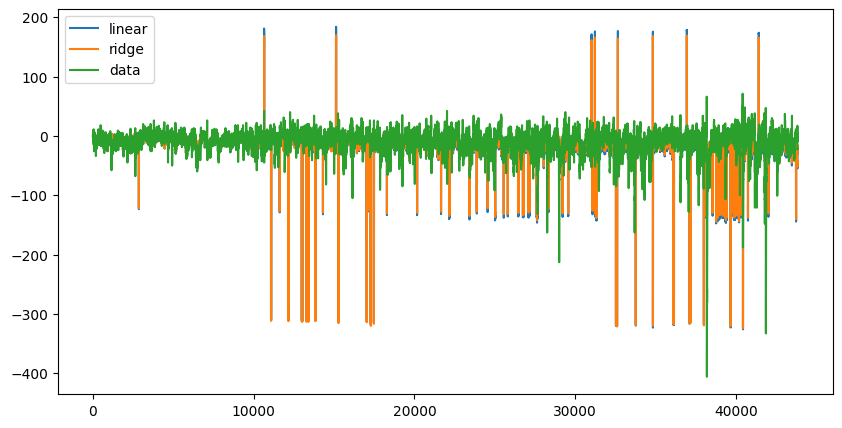

In [7]:
#モジュールの読み込み
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

# 通常の線形モデルの作成と予測
lr = LinearRegression()# LinearRegressionのインスタンスの作成
lr.fit(x_train, y_train)# 上で作ったオブジェクトの学習
y_pred_valid_lr = lr.predict(x_valid)#　検証データに対する予測

#Ridge回帰モデルの作成と予測
ridge = Ridge(alpha=100.0, fit_intercept=False, solver="svd")  # (for version 1.2.2)
ridge.fit(x_train, y_train)
y_pred_valid_rr = ridge.predict(x_valid)

import matplotlib.pyplot as plt
xplot = np.arange(n_valid) # 0,1,2...n_valid-1のような配列になる
plt.figure(figsize=(10,5)) #figsize => (x,y)の図のサイズ
plt.plot(xplot,y_pred_valid_lr,label="linear") #label; 凡例の文字
plt.plot(xplot,y_pred_valid_rr,label="ridge") #label; 凡例の文字
plt.plot(xplot,y_valid,label="data")
plt.legend() #凡例を表示
plt.show()